# Photo-z Validation

Adaptaded from: https://github.com/linea-it/OLD-pz-lsst-inkind/blob/main/ondemand/2.pz-compute-template.ipynb

# Imports and auxiliary functions

In [19]:
import tables_io
import getpass
import os
import qp 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import ondemand_utils as utils
#from pzserver import PzServer

utils.run_command("pwd")

/scratch/users/andreia.dourado


In [3]:
cwd = os.getcwd()

in case ondemand_utils.utils does not import correctly, please run on your terminal: 

>```python 
> pip install -e $SCRATCH/pz-compute/ondemand/ondemand_utils/. 
>```

or uncomment the following cell and after running it, restart your kernel.

In [ ]:
! pip install -e $SCRATCH/pz-compute/ondemand/ondemand_utils/. 

In [ ]:
%%skip_if not will_train

## todo implement here basic qa

In [ ]:
%%skip_if not will_train

pz_train_configs = utils.load_config("pz-train.yaml")
pz_train_configs['inputfile'] = train_file_hdf5
pz_train_configs

In [ ]:
%%skip_if not will_train
with open('pz-train.yaml', 'w') as outfile:
    yaml.dump(pz_train_configs, outfile)

utils.load_config('pz-train.yaml')

In [ ]:
%%skip_if not will_train

train_configs = utils.load_config(pz_train_configs['param_file'])
train_configs

In [ ]:
%%skip_if not will_train
# utils.run_pz_train()

### SUBMIT TRAINING JOB

Once these files are with all the configs you want to, run on of the following commands in the terminal:

>```python 
>pz-train-dev or pz-train
>```


In [ ]:
%%skip_if not will_train

pz_train_job_id = utils.get_last_job_id()
utils.monitor_job(pz_train_job_id)

### PZ estimates for the Test Set

For details over the fields for the yamls look into: https://github.com/linea-it/pz-compute/tree/main/doc/manpages

Run `rail_estimate` module to produce the photo-z estimates (PDFs) for the Test Set. 

In [ ]:
%%skip_if not will_train

utils.load_config('process_info.yaml')

In [ ]:
%%skip_if not will_train

!mkdir input_test
!mkdir output_test

In [ ]:
%%skip_if not will_train

!mv {test_file_hdf5} input_test

In [ ]:
%%skip_if not will_train

pz_compute_configs = utils.load_config('pz-compute.yaml')
pz_compute_configs['inputdir'] = 'input_test'
pz_compute_configs['outputdir'] = 'output_test'
pz_compute_configs

In [ ]:
%%skip_if not will_train
with open('pz-compute.yaml', 'w') as outfile:
    yaml.dump(pz_compute_configs, outfile)

utils.load_config('pz-compute.yaml')

In [ ]:
%%skip_if not will_train

utils.load_config(pz_compute_configs['param_file'])

In [ ]:
%%skip_if not will_train

# utils.run_pz_compute()

### Run test pz-compute

Once these files are with all the configs you want to, run on of the following commands in the terminal:

>```python 
>pz-compute-dev or pz-compute
>```

### Monitor run test pz-compute

In [ ]:
%%skip_if not will_train

pz_compute_job_id = utils.get_last_job_id()
utils.monitor_job(pz_compute_job_id)

# Post-processing

In [4]:
process_info = utils.load_config('/scratch/users/app.photoz/teste_andreia/process_info.yaml' )
process_info

{'algorithm': 'tpz',
 'comment': 'comments',
 'process_id': 'teste_andreia',
 'user': 'app.photoz',
 'will_train': False}

##  Performance evaluation 

In [5]:
utils.run_post_process_evaluation()


Reading /scratch/users/app.photoz/teste_andreia/slurm-10449.out file

Starting time rail-estimate: 2025-08-04 12:39:34.472172
Finished time rail-estimate: 2025-08-04 12:43:31.824276
Total duration rail-estimate: 0:03:57.352104

1229/1229 files processed
Output size: 60G

Building plots...
Output files have z-modes
Output files have yvals (pdfs)

Information saved in process_info.yaml


In [6]:
process_info = utils.load_config('/scratch/users/app.photoz/teste_andreia/process_info.yaml')
process_info

{'algorithm': 'tpz',
 'comment': 'comments',
 'process_id': 'teste_andreia',
 'user': 'app.photoz',
 'will_train': False}

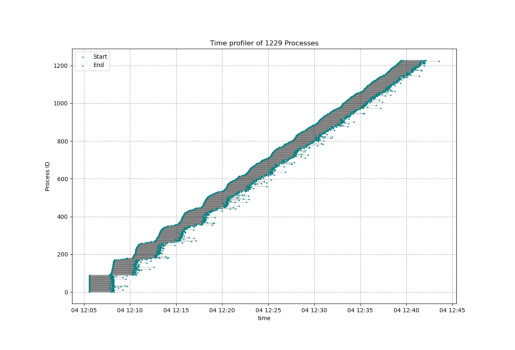

In [7]:
img = mpimg.imread('processes_time_profiler.png')

plt.imshow(img)
plt.axis('off')
plt.show()

## PZ Estimates - QA of final results 

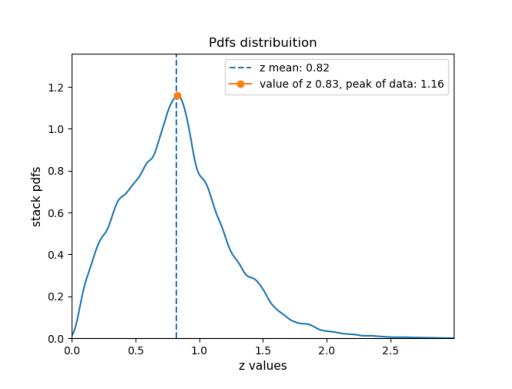

In [8]:
if os.path.isfile('stack_pdfs.png'):
    img = mpimg.imread('stack_pdfs.png')

    plt.imshow(img)
    plt.axis('off')
    plt.show()

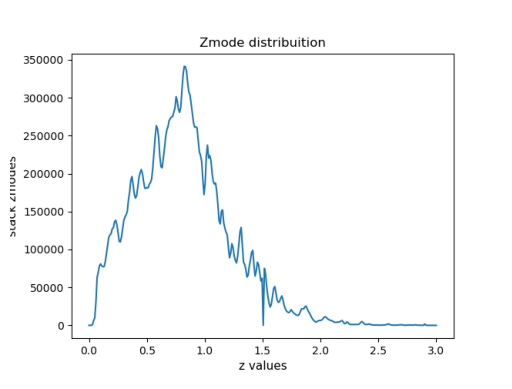

In [9]:
if os.path.isfile('stack_zmode.png'):
    img = mpimg.imread('stack_zmode.png')

    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [11]:
table = qp.read('stacked_output_pdfs.hdf5')

In [12]:
test_xvals = table.gen_obj.xvals
test_xvals.shape

(301,)

In [13]:
pdfs = table.pdf(test_xvals)

In [14]:
df = pd.read_csv('stacked_zmodes.csv')

In [15]:
data = df.sum(axis=0)

In [16]:
data.drop(['objects'], inplace=True)

In [17]:
counts, bin_edges = np.histogram(data, bins=300)

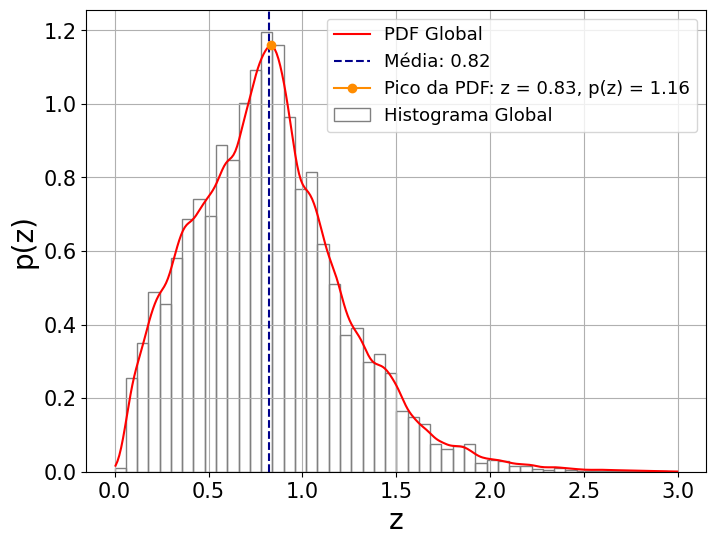

In [18]:
counts = data.values 

bins = 50
group_size = len(counts) // bins 

new_counts = counts[:bins * group_size].reshape(bins, group_size).sum(axis=1)

bin_edges = np.linspace(0, 3, bins + 1) 
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

area_total = np.sum(new_counts * bin_width)
normalized_counts = new_counts / area_total

fig = plt.figure(figsize=(8, 6))

plt.bar(bin_centers, normalized_counts, width=bin_width, align='center', alpha=1, edgecolor='gray',facecolor='none', label='Histograma Global')
plt.plot(test_xvals, pdfs, color='red', label='PDF Global')
plt.axvline(0.82, label=f'Média: 0.82', linestyle='--', color='darkblue')
plt.plot(0.83, 1.16, marker = 'o', label=f'Pico da PDF: z = 0.83, p(z) = 1.16', color='darkorange')

plt.xlabel('z', fontsize=20)
plt.ylabel('p(z)', fontsize=20)
plt.legend(fontsize = 13)
plt.tick_params(axis='both', labelsize=15)

plt.grid(True)
plt.savefig(f'./dados_tcc/metrics/validation/n(z)_global.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
